# Global Imports

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any

# Local Imports

In [12]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Define Paths

In [13]:
notebook_dir: str = os.path.abspath(".")
data_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir,
    "data",
    "lambda"
)

file_names: list[str] = [
    "u3bb-1736974468605.png",
    "u2e-1736974503521.png",
    "u31-1736974480810.png"
]

labels: list[str] = [
    "u3bb",
    "u2e",
    "u31"
]

file_paths: list[str] = [
    os.path.join(
        data_dir,
        file_name
    ) for file_name in
    file_names
]


# Load Dataset

In [14]:

char_dataset: CharImageDataset = CharImageDataset(
    file_paths=file_paths,
    labels=labels,
    rotation_limit=0.1,
    translation_limit=0.2,
    skew_limit=0.05,
    zoom_change=0.3,
    image_dims=(64, 64)
)




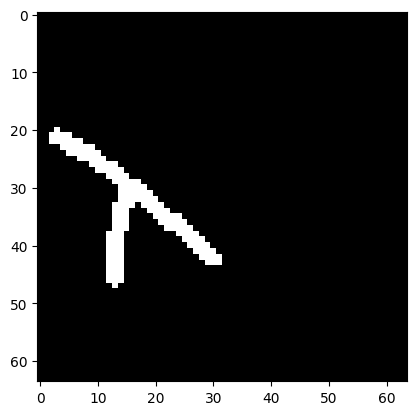

tensor([1., 0., 0.])


In [15]:
for im, lab in char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [16]:
train_dataloader: DataLoader = DataLoader(
    char_dataset,
    shuffle=True
)

# Define Model Hyperparameters

In [19]:

all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 16),
        "fully_connected_features": (3,),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "verbose": False
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.000001,
        "weight_decay": 0.00001
    }
]


# Train

In [20]:
for epoch in range(100):

    log: EpochLogs
    for log in grid_search(
        model_factor=AllCNN2D,
        all_model_parameters=all_model_parameters,
        optim_factory=AdamW,
        all_optim_params=all_optim_parameters,
        epochs=100,
        criterion=nn.CrossEntropyLoss(),
        train_dataloader=train_dataloader,
        val_dataloader=train_dataloader,
        lr_decay_window_size=10,
        lr_decay_minimum=0.0,
        device="cuda"
    ):
        train_logpoints: list[LogPoint] = log.train_logs
        
        log_point: LogPoint = train_logpoints[0] 
        
        y_hat_pred: torch.Tensor = torch.argmax(log_point.y_hat)
        y_pred: torch.Tensor = torch.argmax(log_point.y)
        
        print(y_hat_pred.detach().cpu().item(), y_pred.detach().cpu().item())
        

Validating Model...: 100%|██████████| 3/3 [00:00<00:00, 19.11it/s]


0 2


Validating Model...: 100%|██████████| 3/3 [00:00<00:00, 17.96it/s]


0 0


Validating Model...: 100%|██████████| 3/3 [00:00<00:00, 19.23it/s]


0 2


Validating Model...: 100%|██████████| 3/3 [00:00<00:00, 19.36it/s]


0 2


Validating Model...: 100%|██████████| 3/3 [00:00<00:00, 19.74it/s]


2 1


Validating Model...: 100%|██████████| 3/3 [00:00<00:00, 19.87it/s]


0 2


Validating Model...: 100%|██████████| 3/3 [00:00<00:00, 20.83it/s]


0 0


Validating Model...: 100%|██████████| 3/3 [00:00<00:00, 19.61it/s]


0 2


Validating Model...: 100%|██████████| 3/3 [00:00<00:00, 15.87it/s]


0 0


Validating Model...: 100%|██████████| 3/3 [00:00<00:00, 17.43it/s]


0 0


Validating Model...:  33%|███▎      | 1/3 [00:00<00:00, 13.89it/s]


KeyboardInterrupt: 